# Introducción a las prácticas de laboratorio de Deep Learning y sus Aplicaciones

## 2 - Otro ejemplo más complicado: el problema de las dos espirales

Es altamente no lineal. Aquí se va a ver en 2 dimensiones (se puede generalizar a más dimensiones, como ocurre con el problema del ExcluiveOR).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import History


print ("Versiones")
print ("numpy:", np.__version__)
print ("pandas:", pd.__version__)
print ("tensorflow:", tf.__version__)


In [ ]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

# X son las coordenadas (x,y) de cada punto.
# y son los valores o clases


plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [ ]:
# Crear y entrenar el mlp

history = History ()

model = Sequential()
model.add(Input(shape=(2,)))
model.add(layers.Dense(8, activation='tanh', name='Oculta1'))
model.add(layers.Dense(6, activation='tanh', name='Oculta2'))
model.add(layers.Dense(4, activation='tanh', name='Oculta3'))
model.add(layers.Dense(1, activation='sigmoid', name="Salida"))

opt = RMSprop (learning_rate=0.01, momentum=0.0, epsilon=1e-7)

model.compile(loss='binary_crossentropy', optimizer=opt)

model.fit(X, y, epochs=100, batch_size=10, verbose=0, callbacks=[history])

epochs=history.epoch
loss=history.history['loss']

plt.scatter (epochs, loss)

In [ ]:
# Una representación gráfica algo espectacular...
Pasos=20
x0=np.linspace (-10.0, 10.0, Pasos)
y0=np.linspace (-10.0, 10.0, Pasos)

SalidaPrueba = np.empty (0)

for y_prueba in y0:
  for x_prueba in x0:
    EntradaPrueba=np.array ([[x_prueba, y_prueba]], dtype=np.float32)
    z=model.predict (EntradaPrueba)
    SalidaPrueba=np.append (SalidaPrueba, z)


plt.contourf (x0, y0, SalidaPrueba.reshape (Pasos, Pasos), 20)

## Trabajo un poco más serio
Vamos a intentar estimar la capacidad de generalización de la red, probando el modelo con datos no vistos durante el entrenamiento.

In [ ]:
# Dividir los datos en entrenamiento y prueba.

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size=0.1)

### Crear funciones útiles
Como hemos visto en el apartado anterior que somos capaces de reproducir las dos espirales con una red neuronal artificial, vamos a crear un par de funciones englobando ese código y así poder reutilizarlo varias veces con la posibilidad de cambiar parámetros en cada ocasión.

In [ ]:
# Función que crea y entrena el mlp

def mi_mlp (npe1=8, npe2=8, epocas=100, lr=0.001):
    # Fíjate en los valores por defecto de los parámetros
    history = History ()

    print ("Parámetros:",npe1, npe2, epocas, lr)

    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(layers.Dense(npe1, activation='tanh', name="Oculta1"))
    model.add(layers.Dense(npe2, activation='tanh', name="Oculta2"))
    model.add(layers.Dense(1, activation='sigmoid', name="Salida"))

    opt = RMSprop(learning_rate=0.01, momentum=0.0, epsilon=1e-7)

    model.compile(loss='binary_crossentropy', optimizer=opt)

    model.fit(X_train, Y_train, epochs=epocas, batch_size=10, verbose=0, callbacks=[history])

    #epochs=history.epoch
    #loss=history.history['loss']

    #plt.scatter (epochs, loss)
    #plt.show()
    return model

In [ ]:
# Función que visualiza las espirales generadas por el modelo

def DibujaEspiral (modelo):
    model=modelo
    Pasos=20
    x0=np.linspace (-10.0, 10.0, Pasos)
    y0=np.linspace (-10.0, 10.0, Pasos)

    SalidaPrueba = np.empty (0)

    for y_prueba in y0:
      for x_prueba in x0:
        EntradaPrueba=np.array ([[x_prueba, y_prueba]], dtype=np.float32)
        z=model.predict(EntradaPrueba)
        SalidaPrueba=np.append (SalidaPrueba, z)


    plt.contourf (x0, y0, SalidaPrueba.reshape (Pasos, Pasos), 20)
    plt.show()

Parámetros: 8 8 1000 0.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━

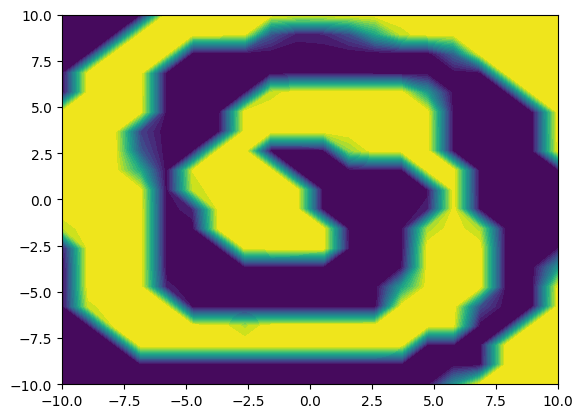

In [8]:
modelo=mi_mlp ()
DibujaEspiral(modelo)

Calculemos el error que se comete en el conjunto de prueba.

In [9]:
# ¡OJO! Este primer cálculo usa el error cuadrático medio.
z=model.predict (X_test)
e=z-Y_test.reshape ((200,1))
print ((e**2).mean ())

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
0.11846548697677513


In [10]:
# Pero lo que deberíamos ver es el número de puntos correctamente/erróneamente clasificados
# Para ello hay que binarizar la salida z:

eabs=abs (e)
fallos=0
for v in eabs:
    if v >= 0.5:
        fallos=fallos + 1

print (fallos)

32


### Aleatoriedad y Reproductibilidad de los experimentos
El resultado del algoritmo de aprendizaje depende de cómo inicialicemos los pesos.
Hay que repetir MUCHAS veces los experimentos y hacer estadísticas.
Por sí solo, Keras y Tensorflow ya incorporan un mecanismo de inicialización aleatoria de los pesos, cuya semilla se ajusta automáticamente.
Solo tienes que repetir el enrenamiento con los mismos datos y obtienes resultados diferentes.
Si quieres poder tener reproductivilidad en los experimentos, usa el método set_seed (X), que fuerza a usar la semilla que especifiques.

In [11]:
# Vamos a repetir el experimento (entrenar-probar) cinco veces.
# Pero para que sea más rápido, vamos cambiar los parámetros.

for vez in [1,2,3]:
    modelo=mi_mlp (epocas=10)
    z=modelo.predict (X_test)
    e=z-Y_test.reshape ((200,1))
    print (vez, (e**2).mean ())

Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1 0.23607286954067153
Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2 0.22856009489963555
Parámetros: 8 8 10 0.001


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3 0.24301216159781439


In [12]:
# Ahora controlamos la aleatoriedad

import tensorflow

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed # Ya no es necesario
for vez in [1,2,3,4,5]:
    tensorflow.random.set_seed(2)
    modelo=mi_mlp (epocas=10)
    z=modelo.predict (X_test)
    e=z-Y_test.reshape ((200,1))
    print (vez, (e**2).mean ())



Parámetros: 8 8 10 0.001


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
1 0.2384984750163567
Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2 0.24259421014700167
Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
3 0.24713579372809918
Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4 0.24274988529959698
Parámetros: 8 8 10 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5 0.2413564405340825


### Optimización de hiperparámetros
Como habrás observaddo, al declarar la función mi_mlp hemos incluido la posibilidad de variar algunos de los hiperparámetros pasando el nuevo valor como argumento.


Busqemos alguna combinación que mejore los resultados. Para ello símplemente vamos a hacer un barrido y calcular el número puntos erróneamente asignados.

In [16]:
dfResultados=pd.DataFrame (columns=["npe1", "npe2", "lcoef", "Fallos"])

for capa1 in [2, 4, 8, 16]:
    for capa2 in [2, 3, 4, 5]:
        for lcoef in [0.01, 0.001, 0.0001]:
            modelo=mi_mlp(npe1=capa1, npe2=capa2, epocas=100, lr=lcoef)
            z=modelo.predict (X_test)
            e=z-Y_test.reshape ((200,1))
            eabs=abs (e)
            fallos=0
            for v in eabs:
                if v >= 0.5:
                    fallos=fallos + 1

            dfResultados.loc[len(dfResultados)]=[capa1, capa2, lcoef, fallos]

dfResultados

Parámetros: 2 2 100 0.01
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Parámetros: 2 2 100 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 2 100 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Parámetros: 2 3 100 0.01
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 3 100 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 3 100 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Parámetros: 2 4 100 0.01
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Parámetros: 2 4 100 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 4 100 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Parámetros: 2 5 100 0.01
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 5 100 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 2 5 100 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Parámetros: 4 2 100 0.01
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 4 2 100 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Parámetros: 4 2 100 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Parámetros: 4 3 100 0.01
7/7 ━━━━━━━━━━━

,npe1,npe2,lcoef,Fallos
0,2.0,2.0,0.0100,89.0
1,2.0,2.0,0.0010,71.0
2,2.0,2.0,0.0001,80.0
3,2.0,3.0,0.0100,91.0
4,2.0,3.0,0.0010,74.0
5,2.0,3.0,0.0001,89.0
6,2.0,4.0,0.0100,91.0
7,2.0,4.0,0.0010,76.0
8,2.0,4.0,0.0001,96.0
9,2.0,5.0,0.0100,71.0


In [17]:
# Esta celda está comentada porque no queremos perder el contenido del fichero que hemos creado hace un rato.

dfResultados.to_csv ("Resultados_2Espirales.csv")

In [ ]:

dfResultados=pd.read_csv ("Resultados_2Espirales.csv")

In [18]:
dfResultados

,npe1,npe2,lcoef,Fallos
0,2.0,2.0,0.0100,89.0
1,2.0,2.0,0.0010,71.0
2,2.0,2.0,0.0001,80.0
3,2.0,3.0,0.0100,91.0
4,2.0,3.0,0.0010,74.0
5,2.0,3.0,0.0001,89.0
6,2.0,4.0,0.0100,91.0
7,2.0,4.0,0.0010,76.0
8,2.0,4.0,0.0001,96.0
9,2.0,5.0,0.0100,71.0


In [19]:
dfResultados=dfResultados.pivot(index=["npe1", "lcoef"],columns="npe2",values="Fallos")
dfResultados.style.highlight_min ()